In [1]:
#import libraries
from datetime import datetime
from time import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import warnings

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = Path("./input")
path.ls()

[PosixPath('input/test_images'),
 PosixPath('input/.DS_Store'),
 PosixPath('input/train.csv'),
 PosixPath('input/train_images')]

In [4]:
path_img = path/"train_images"

fnames_train = get_image_files(path_img)
fnames_train[:3]
print(len(fnames_train))

5546


In [5]:
path_test = path/"test_images"

fnames_test = get_image_files(path_test)
fnames_test[:3]
print(len(fnames_test))

3698


In [6]:
img_f = fnames_train[1]
img = open_image(img_f)
#img.show(figsize=(10, 10))

In [7]:
def split_img_label(img_lbl):
    """Return image and label from file name like '0011165.jpg_Flower'"""
    s = img_lbl.split("_")
    assert len(s) == 2
    return s[0], s[1]

In [8]:
train = pd.read_csv(f'{path}/train.csv')

# split Image_Label
train["Image"] = train["Image_Label"].apply(lambda img_lbl: split_img_label(img_lbl)[0])
train["Label"] = train["Image_Label"].apply(lambda img_lbl: split_img_label(img_lbl)[1])
del train["Image_Label"]

train.head()

,EncodedPixels,Image,Label
0,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,NaN,0011165.jpg,Gravel
3,NaN,0011165.jpg,Sugar
4,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish


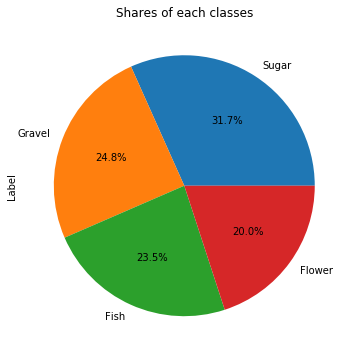

In [9]:
train_with_mask = train.dropna(subset=["EncodedPixels"])
ax = train_with_mask["Label"].value_counts().plot(kind="pie", autopct='%1.1f%%', title="Shares of each classes", figsize=(10, 6))

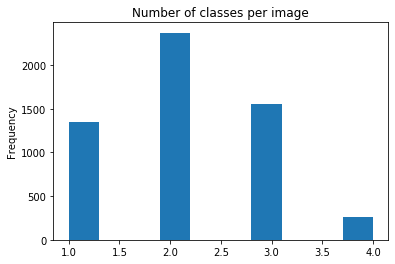

In [10]:
class_counts = train.dropna(subset=["EncodedPixels"]).groupby("Image")["Label"].nunique()
ax = class_counts.plot(kind="hist", title="Number of classes per image")

In [11]:
# pivot to have one row per image and masks as columns
train = train.pivot(index='Image', columns='Label', values='EncodedPixels')
assert len(train) == len(fnames_train) # sanity check
train.head()

Label,Fish,Flower,Gravel,Sugar
Image,,,,
0011165.jpg,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN
002be4f.jpg,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...
0031ae9.jpg,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...
0035239.jpg,NaN,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,NaN
003994e.jpg,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...


In [12]:
def show_img_fn(fname, figsize=(10, 10)): #Show irregular/unusual Images
    img = open_image(fname)
    img.show(figsize=figsize)    

In [13]:
def show_img_info(fname):
    show_img_fn(path_img/fname)
    display(train.loc[[fname]])   

In [14]:
unusual_imgs = ["1588d4c.jpg", "c0306e5.jpg", "c26c635.jpg", "fa645da.jpg", "41f92e5.jpg", "e5f2f24.jpg"]

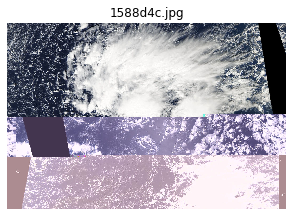

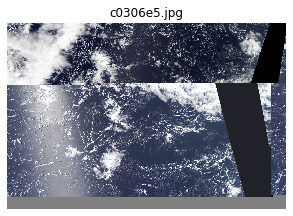

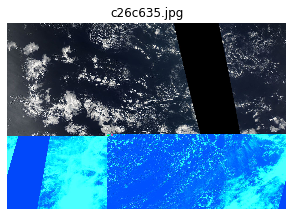

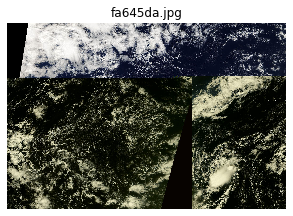

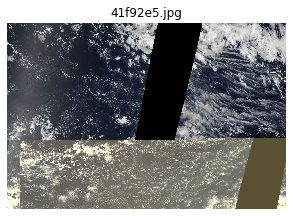

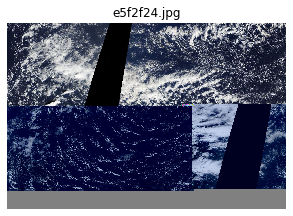

In [15]:
for fname in unusual_imgs:
    img = open_image(path_img/fname)
    img.show(figsize=(5, 5), title=fname)     

In [20]:
train_img_dims = (1400, 2100)  # Train and test images are 1400x2100 pixels

In [21]:
def rle_to_mask(rle, shape):
    mask_img = open_mask_rle(rle, shape)
    mask = mask_img.px.permute(0, 2, 1)
    return mask

In [22]:
def mask_to_rle(mask): #convert masks to rle
    return rle_encode(mask.numpy().T)

torch.Size([1, 1400, 2100])


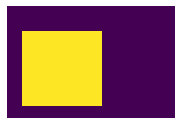

In [23]:
def test_mask_rle(): # test case for mask RLE encode/decode
    mask_rle = train.iloc[0]["Fish"]    
    mask = rle_to_mask(mask_rle, train_img_dims)
    mask_rle_enc = mask_to_rle(mask)
    assert mask_rle_enc == mask_rle
    
    print(mask.shape)
    Image(mask).show()
    
test_mask_rle()

In [24]:
item_list = (SegmentationItemList.
             from_df(df=train.reset_index(), path=path_img, cols="Image")
             .use_partial_data(sample_pct=0.1)  # use only a subset of data to speedup tests
             .split_by_rand_pct(0.2))

In [25]:
class MultiLabelImageSegment(ImageSegment):

    def show(self, ax:plt.Axes=None, figsize:tuple=(3,3), title:Optional[str]=None, hide_axis:bool=True,
        cmap:str='tab20', alpha:float=0.5, class_names=None, **kwargs):
        "Show the masks on `ax`."
             
        # put all masks into a single channel
        flat_masks = self.px[0:1, :, :].clone()
        for idx in range(1, self.shape[0]): # shape CxHxW
            mask = self.px[idx:idx+1, :, :] # slice tensor to a single mask channel
            # use powers of two for class codes to keep them distinguishable after sum 
            flat_masks += mask * 2**idx
        
        # use same color normalization in image and legend
        norm = matplotlib.colors.Normalize(vmin=0, vmax=2**self.shape[0]-1)
        ax = show_image(Image(flat_masks), ax=ax, hide_axis=hide_axis, cmap=cmap, norm=norm,
                        figsize=figsize, interpolation='nearest', alpha=alpha, **kwargs)
        
        # custom legend
        cm = matplotlib.cm.get_cmap(cmap)
        legend_elements = []
        for idx in range(self.shape[0]):
            c = 2**idx
            label = class_names[idx] if class_names is not None else f"class {idx}"
            line = Line2D([0], [0], color=cm(norm(c)), label=label, lw=4)
            legend_elements.append(line)
        ax.legend(handles=legend_elements)
        
        # debug info
        # ax.text(10, 10, f"px={self.px.size()}", {"color": "white"})
        
        if title: ax.set_title(title)

    def reconstruct(self, t:Tensor): 
        return MultiClassImageSegment(t)

In [26]:
def bce_logits_floatify(input, target, reduction='mean'):
    return F.binary_cross_entropy_with_logits(input, target.float(), reduction=reduction)

In [27]:
class MultiLabelSegmentationLabelList(SegmentationLabelList):
    """Return a single image segment with all classes"""
    # adapted from https://forums.fast.ai/t/how-to-load-multiple-classes-of-rle-strings-from-csv-severstal-steel-competition/51445/2
    
    def __init__(self, items:Iterator, src_img_size=None, classes:Collection=None, **kwargs):
        super().__init__(items=items, classes=classes, **kwargs)
        self.loss_func = bce_logits_floatify
        self.src_img_size = src_img_size
        # add attributes to copy by new() 
        self.copy_new += ["src_img_size"]
    
    def open(self, rles):        
        # load mask at full resolution
        masks = torch.zeros((len(self.classes), *self.src_img_size)) # shape CxHxW
        for i, rle in enumerate(rles):
            if isinstance(rle, str):  # filter out NaNs
                masks[i] = rle_to_mask(rle, self.src_img_size)
        return MultiLabelImageSegment(masks)
    
    def analyze_pred(self, pred, thresh:float=0.0):
        # binarize masks
        return (pred > thresh).float()
    
    def reconstruct(self, t:Tensor): 
        return MultiLabelImageSegment(t)

In [28]:
class_names = ["Fish", "Flower", "Gravel", "Sugar"]

In [29]:
def get_masks_rle(img):
    """Get RLE-encoded masks for this image"""
    img = img.split("/")[-1]  # get filename only
    return train.loc[img, class_names].to_list()

In [30]:
# reduce image size
img_size = (84, 132)  # use multiple of 4
img_size

(84, 132)

In [31]:
classes = [0, 1, 2, 3] # no need for a "void" class: if a pixel isn't in any mask, it is not labelled
item_list = item_list.label_from_func(func=get_masks_rle, label_cls=MultiLabelSegmentationLabelList, 
                                      classes=classes, src_img_size=train_img_dims)

In [32]:
# add unlabelled test images
item_list = item_list.add_test_folder(path_test, label="")

In [33]:
batch_size = 8

#add data augmentation
tfms = ([], [])
item_list = item_list.transform(tfms, tfm_y=True, size=img_size)

In [34]:
data = (item_list
        .databunch(bs=batch_size)
        .normalize(imagenet_stats) # use same stats as pretrained model
       )  
assert data.test_ds is not None

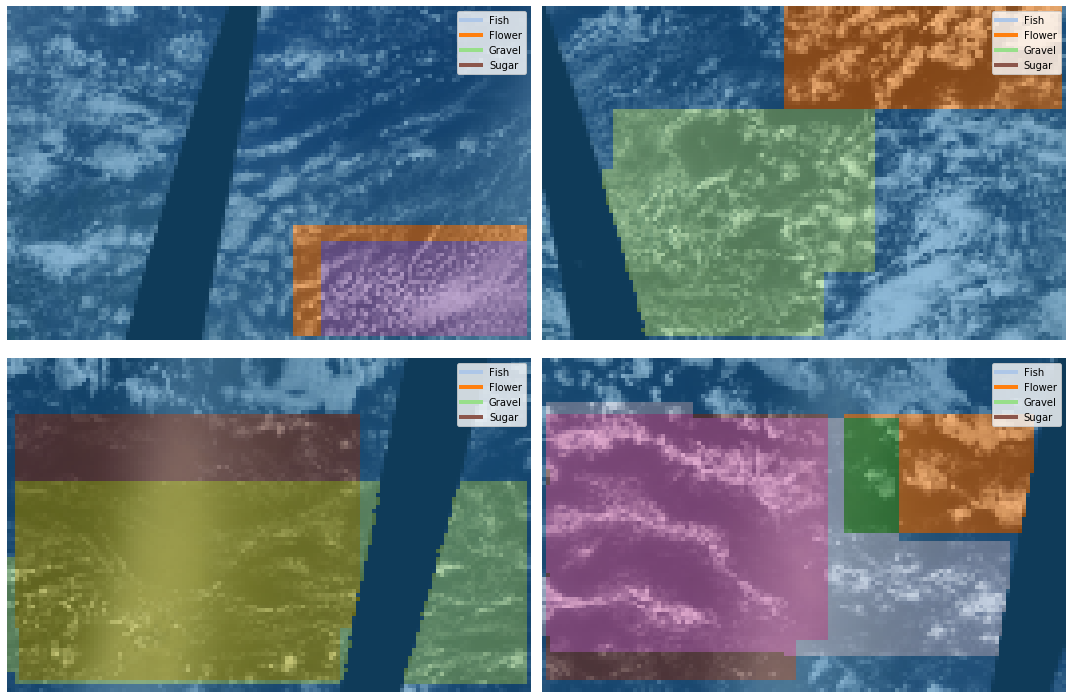

In [35]:
data.show_batch(2, figsize=(15, 10), class_names=class_names)

In [44]:
# can use sigmoid on the input too, in this case the threshold would be 0.5
def dice_metric(pred, targs, threshold=0):
    pred = (pred > threshold).float()
    targs = targs.float()  # make sure target is float too
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

In [54]:
metrics = [dice_metric]

callback_fns = [
    # update a graph of learner stats and metrics after each epoch
    ShowGraph,

    # save model at every metric improvement
    partial(SaveModelCallback, every='improvement', monitor='dice_metric', name=f"20190925-122022_unet_resnet18_stage1_best"),
    
    # stop training if metric no longer improve
    partial(EarlyStoppingCallback, monitor='dice_metric', min_delta=0.01, patience=2),
]

learn = unet_learner(data, models.resnet18, metrics=metrics, wd=1e-2, callback_fns=callback_fns)
learn.model_dir = "./models/"  # point to writable directory

In [55]:
learn.loss_func

<function __main__.bce_logits_floatify(input, target, reduction='mean')>

In [56]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 42, 66]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 42, 66]         128        True      
______________________________________________________________________
ReLU                 [64, 42, 66]         0          False     
______________________________________________________________________
MaxPool2d            [64, 21, 33]         0          False     
______________________________________________________________________
Conv2d               [64, 21, 33]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 21, 33]         128        True      
______________________________________________________________________
ReLU                 [64, 21, 33]         0          False     
__________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


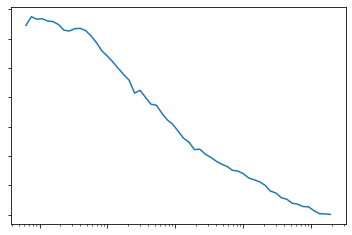

In [57]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(15, max_lr=1e-4)

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save(f"20190925-124401_unet_resnet18_stage1", return_path=True)

In [ ]:
learn.unfreeze() #Unfreeze and differential learning rate

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
# slice(start,end) syntax: the first group's learning rate is start, the last is end, and the remaining are evenly geometrically spaced
learn.fit_one_cycle(15, max_lr=slice(1e-6, 1e-5))

In [ ]:
learn.save(f"20190925-125230_unet_resnet18_stage2", return_path=True)

In [ ]:
learn.show_results(imgsize=8, class_names=class_names) #Predictions

In [ ]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test, with_loss=False) #Get predictions for test images

In [ ]:
learn.show_results(ds_type=DatasetType.Test, imgsize=8, class_names=class_names)

In [ ]:
for i in range(3): 
    pimg = MultiLabelImageSegment(preds[i] > 0)
    pimg.show(figsize=(6, 6), class_names=class_names)   